# College Football Analysis Using Aggregated Team Data


***
### Summary

This notebook explores college football game data by team for games since 2010. More specifically, it evaluates the relationships between certain features and predicting wins towards the end of a given season. The goal of this analysis is to better understand what specific statistics about a team can be reliably looked at as indicators for the potential to win.

The first part will look at features that will accurately classify a game as Won by a given team. The second part will take the findings from the first model to identify the proper values that need to be predicted. The end product will be a predictive model comprised of two models, one that predicts the feature values based on past performance and oppenents past performance, that are then fed into another model that classifies that game as a Win or Lost based on those values predicted.

ESPN claims their power index is accurate >70% of the time, so this will be the threshold that this analysis will benchmark off of.

In [2]:
#imports used
import pandas as pd
from bqAutoAuth import bqClient
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from random import randint


***
### Data Gathering and Transformations

The data used is webscraped and dropped into bigquery for easy access. It is continuously updated every week during football season. The code for this ETL process is within the Data Pipeline project.

In [3]:
client = bqClient()#this function creates a bigquery Client object and will check default authentication for the google SDK CLI and prompt authentication if none is detected.
qs = """SELECT * FROM `portfolio-project-353016.collegeFootball.Game_Team_Stats` WHERE PossTime LIKE '%:%' AND GameID != '302750030' """#light cleaning within the query
teamStats_df = client.query(qs).result().to_dataframe()
teamStats_df.head()


successful gcloud authentication check


,GameID,Team,isHome,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,PassIntThrown,RushYds,RushAtt,Penalties,FumblesLost,PossTime
0,401012281,UTEP Miners,False,0,7,2-14,0-0,134,39,9-23,0,95,28,6-42,0,26:36
1,312600333,North Texas Mean Green,False,0,11,5-17,0-1,169,101,13-31,0,68,32,8-68,0,19:33
2,401403886,Georgia Tech Yellow Jackets,True,0,13,6-18,0-2,214,161,18-32,0,53,34,4-25,0,29:07
3,401404149,UConn Huskies,False,0,6,2-14,0-2,110,24,5-20,0,86,33,5-45,1,25:53
4,401282202,Rice Owls,False,0,14,5-13,0-0,272,128,19-24,0,144,32,6-40,1,30:34


Some additional cleaning steps are required. Fields that are a combination of two stats such as PassCompAtt or ThirdDownEff need to be split up. PossTime needs to be converted to a float value as well. These steps will allow greater flexibility in feature engineering later on.

In [4]:
for c in ['ThirdDownEff', 'FourthDownEff', 'PassCompAtt', 'Penalties']:
    teamStats_df[[c, f'{c}Den']] = teamStats_df[c].str.split(pat='-', expand=True)

teamStats_df['PossTime'] = pd.Series([float(val.split(':')[0]) + round(int(val.split(':')[1])/60,2) for val in teamStats_df['PossTime'] if val != 'unavail'])
teamStats_df.head()

,GameID,Team,isHome,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,PassIntThrown,RushYds,RushAtt,Penalties,FumblesLost,PossTime,ThirdDownEffDen,FourthDownEffDen,PassCompAttDen,PenaltiesDen
0,401012281,UTEP Miners,False,0,7,2,0,134,39,9,0,95,28,6,0,26.60,14,0,23,42
1,312600333,North Texas Mean Green,False,0,11,5,0,169,101,13,0,68,32,8,0,19.55,17,1,31,68
2,401403886,Georgia Tech Yellow Jackets,True,0,13,6,0,214,161,18,0,53,34,4,0,29.12,18,2,32,25
3,401404149,UConn Huskies,False,0,6,2,0,110,24,5,0,86,33,5,1,25.88,14,2,20,45
4,401282202,Rice Owls,False,0,14,5,0,272,128,19,0,144,32,6,1,30.57,13,0,24,40


The main table being used contains a record for each team per game, with their respective stats for that game. These fields are offensively focused, but defensive fields can be infered by executing a self join with the opposing team for each game (E.g. the home team's pass yards is the away team's pass yards allowed). Additionally, ensuring all fields have the correct data type will help further prep for analysis.

In [5]:
TShome_df = teamStats_df[teamStats_df['isHome'] == True].copy()
TSaway_df = teamStats_df[teamStats_df['isHome'] == False].copy()

colMap = { 
    'Points': 'PointsAllowed', 
    'FirstDowns': 'FirstDownsAllowed', 
    'ThirdDownEff': 'ThirdDownAllowed',
    'ThirdDownEffDen': 'ThirdDownAllowedDen',
    'FourthDownEff': 'FourthDownAllowed',
    'FourthDownEffDen': 'FourthDownAllowedDen', 
    'TotalYds': 'TotalYdsAllowed', 
    'PassYds': 'PassYdsAllowed', 
    'PassCompAtt': 'PassCompAttAllowed',
    'PassCompAttDen': 'PassCompAttAllowedDen', 
    'PassIntThrown': 'PassInt', 
    'RushYds': 'RushYdsAllowed', 
    'RushAtt': 'RushedAgainstAtt'
 }

keepcol = [
    'GameID',
    'PointsAllowed', 
    'FirstDownsAllowed', 
    'ThirdDownAllowed', 
    'ThirdDownAllowedDen',
    'FourthDownAllowed', 
    'FourthDownAllowedDen',
    'TotalYdsAllowed', 
    'PassYdsAllowed', 
    'PassCompAttAllowed', 
    'PassCompAttAllowedDen',
    'PassInt', 
    'RushYdsAllowed', 
    'RushedAgainstAtt'
]

intcols = [
    "Points",
    "FirstDowns",
    "ThirdDownEff",
    "FourthDownEff",
    "TotalYds",
    "PassYds",
    "PassCompAtt",
    "PassIntThrown",
    "RushYds",
    "RushAtt",
    "Penalties",
    "FumblesLost",
    "ThirdDownEffDen",
    "FourthDownEffDen",
    "PassCompAttDen",
    "PenaltiesDen"
]

dtypes = {x: 'int64' for x in intcols}

TShome_df = TShome_df.astype(dtypes)
TSaway_df = TSaway_df.astype(dtypes)

homeAllowed_df = TSaway_df.copy()
homeAllowed_df = homeAllowed_df.astype(dtypes)
homeAllowed_df = homeAllowed_df.rename(columns=colMap)
homeAllowed_df = homeAllowed_df[keepcol]


awayAllowed_df = TShome_df.copy()
awayAllowed_df = awayAllowed_df.astype(dtypes)
awayAllowed_df = awayAllowed_df.rename(columns=colMap)
awayAllowed_df = awayAllowed_df[keepcol]


TShome_df = TShome_df.merge(homeAllowed_df, on='GameID')
TSaway_df = TSaway_df.merge(awayAllowed_df, on='GameID')

stats_df = pd.concat([TShome_df, TSaway_df], ignore_index=True)
stats_df.head()


,GameID,Team,isHome,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,...,ThirdDownAllowedDen,FourthDownAllowed,FourthDownAllowedDen,TotalYdsAllowed,PassYdsAllowed,PassCompAttAllowed,PassCompAttAllowedDen,PassInt,RushYdsAllowed,RushedAgainstAtt
0,401403886,Georgia Tech Yellow Jackets,True,0,13,6,0,214,161,18,...,15,3,3,547,231,12,19,1,316,62
1,401282791,Colorado Buffaloes,True,0,6,2,0,63,82,12,...,11,1,1,441,164,11,17,0,277,53
2,401282634,Temple Owls,True,3,13,3,1,239,161,17,...,8,1,1,238,59,7,15,1,179,38
3,400547671,SMU Mustangs,True,6,13,7,1,241,139,14,...,11,0,0,663,395,24,37,1,268,31
4,312602459,Northern Illinois Huskies,True,7,11,4,0,237,183,17,...,14,0,0,621,355,24,34,1,266,47


Winners are identified by a new boolean field.

In [6]:
stats_df['Won'] = stats_df['Points'] > stats_df['PointsAllowed']
stats_df.head()

,GameID,Team,isHome,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,...,FourthDownAllowed,FourthDownAllowedDen,TotalYdsAllowed,PassYdsAllowed,PassCompAttAllowed,PassCompAttAllowedDen,PassInt,RushYdsAllowed,RushedAgainstAtt,Won
0,401403886,Georgia Tech Yellow Jackets,True,0,13,6,0,214,161,18,...,3,3,547,231,12,19,1,316,62,False
1,401282791,Colorado Buffaloes,True,0,6,2,0,63,82,12,...,1,1,441,164,11,17,0,277,53,False
2,401282634,Temple Owls,True,3,13,3,1,239,161,17,...,1,1,238,59,7,15,1,179,38,False
3,400547671,SMU Mustangs,True,6,13,7,1,241,139,14,...,0,0,663,395,24,37,1,268,31,False
4,312602459,Northern Illinois Huskies,True,7,11,4,0,237,183,17,...,0,0,621,355,24,34,1,266,47,False


The data is now prepped for analysis.

***
### Exploratory Analysis, Feature Engineering, Feature Selection and Model Selection

Using the pandas dataframe describe method helps provide a high level understanding of each feature.

In [7]:
stats_df.describe()

,Points,FirstDowns,ThirdDownEff,FourthDownEff,TotalYds,PassYds,PassCompAtt,PassIntThrown,RushYds,RushAtt,...,ThirdDownAllowedDen,FourthDownAllowed,FourthDownAllowedDen,TotalYdsAllowed,PassYdsAllowed,PassCompAttAllowed,PassCompAttAllowedDen,PassInt,RushYdsAllowed,RushedAgainstAtt
count,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,...,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000,12378.000000
mean,27.998061,20.513330,5.640814,0.792616,394.144046,233.364356,19.167313,0.896348,163.122071,37.832606,...,14.379221,0.792616,1.550493,394.144046,233.364356,19.167313,32.057198,0.896348,163.122071,37.832606
std,15.058122,6.070033,2.481686,0.945157,124.987615,97.797120,7.452364,0.973347,89.988594,9.666430,...,2.997588,0.945157,1.331071,124.987615,97.797120,7.452364,10.411473,0.973347,89.988594,9.666430
min,0.000000,1.000000,0.000000,0.000000,11.000000,-4.000000,0.000000,0.000000,-73.000000,6.000000,...,4.000000,0.000000,0.000000,11.000000,-4.000000,0.000000,1.000000,0.000000,-73.000000,6.000000
25%,17.000000,16.000000,4.000000,0.000000,306.000000,164.000000,14.000000,0.000000,97.000000,31.000000,...,12.000000,0.000000,1.000000,306.000000,164.000000,14.000000,25.000000,0.000000,97.000000,31.000000
50%,27.000000,20.000000,5.000000,1.000000,392.000000,226.000000,19.000000,1.000000,152.000000,37.000000,...,14.000000,1.000000,1.000000,392.000000,226.000000,19.000000,31.000000,1.000000,152.000000,37.000000
75%,38.000000,25.000000,7.000000,1.000000,476.750000,295.750000,24.000000,1.000000,218.000000,44.000000,...,16.000000,1.000000,2.000000,476.750000,295.750000,24.000000,38.000000,1.000000,218.000000,44.000000
max,84.000000,44.000000,20.000000,7.000000,872.000000,734.000000,58.000000,6.000000,644.000000,86.000000,...,28.000000,7.000000,9.000000,872.000000,734.000000,58.000000,89.000000,6.000000,644.000000,86.000000


Because there are so many features, looking at a correlation matrix will help easily identify multicollinearity and give a quick overview of any features that are correlated with winning.

C:\Users\ostee\AppData\Local\Temp\ipykernel_94588\173723342.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = stats_df.corr(method='pearson')


<AxesSubplot: >

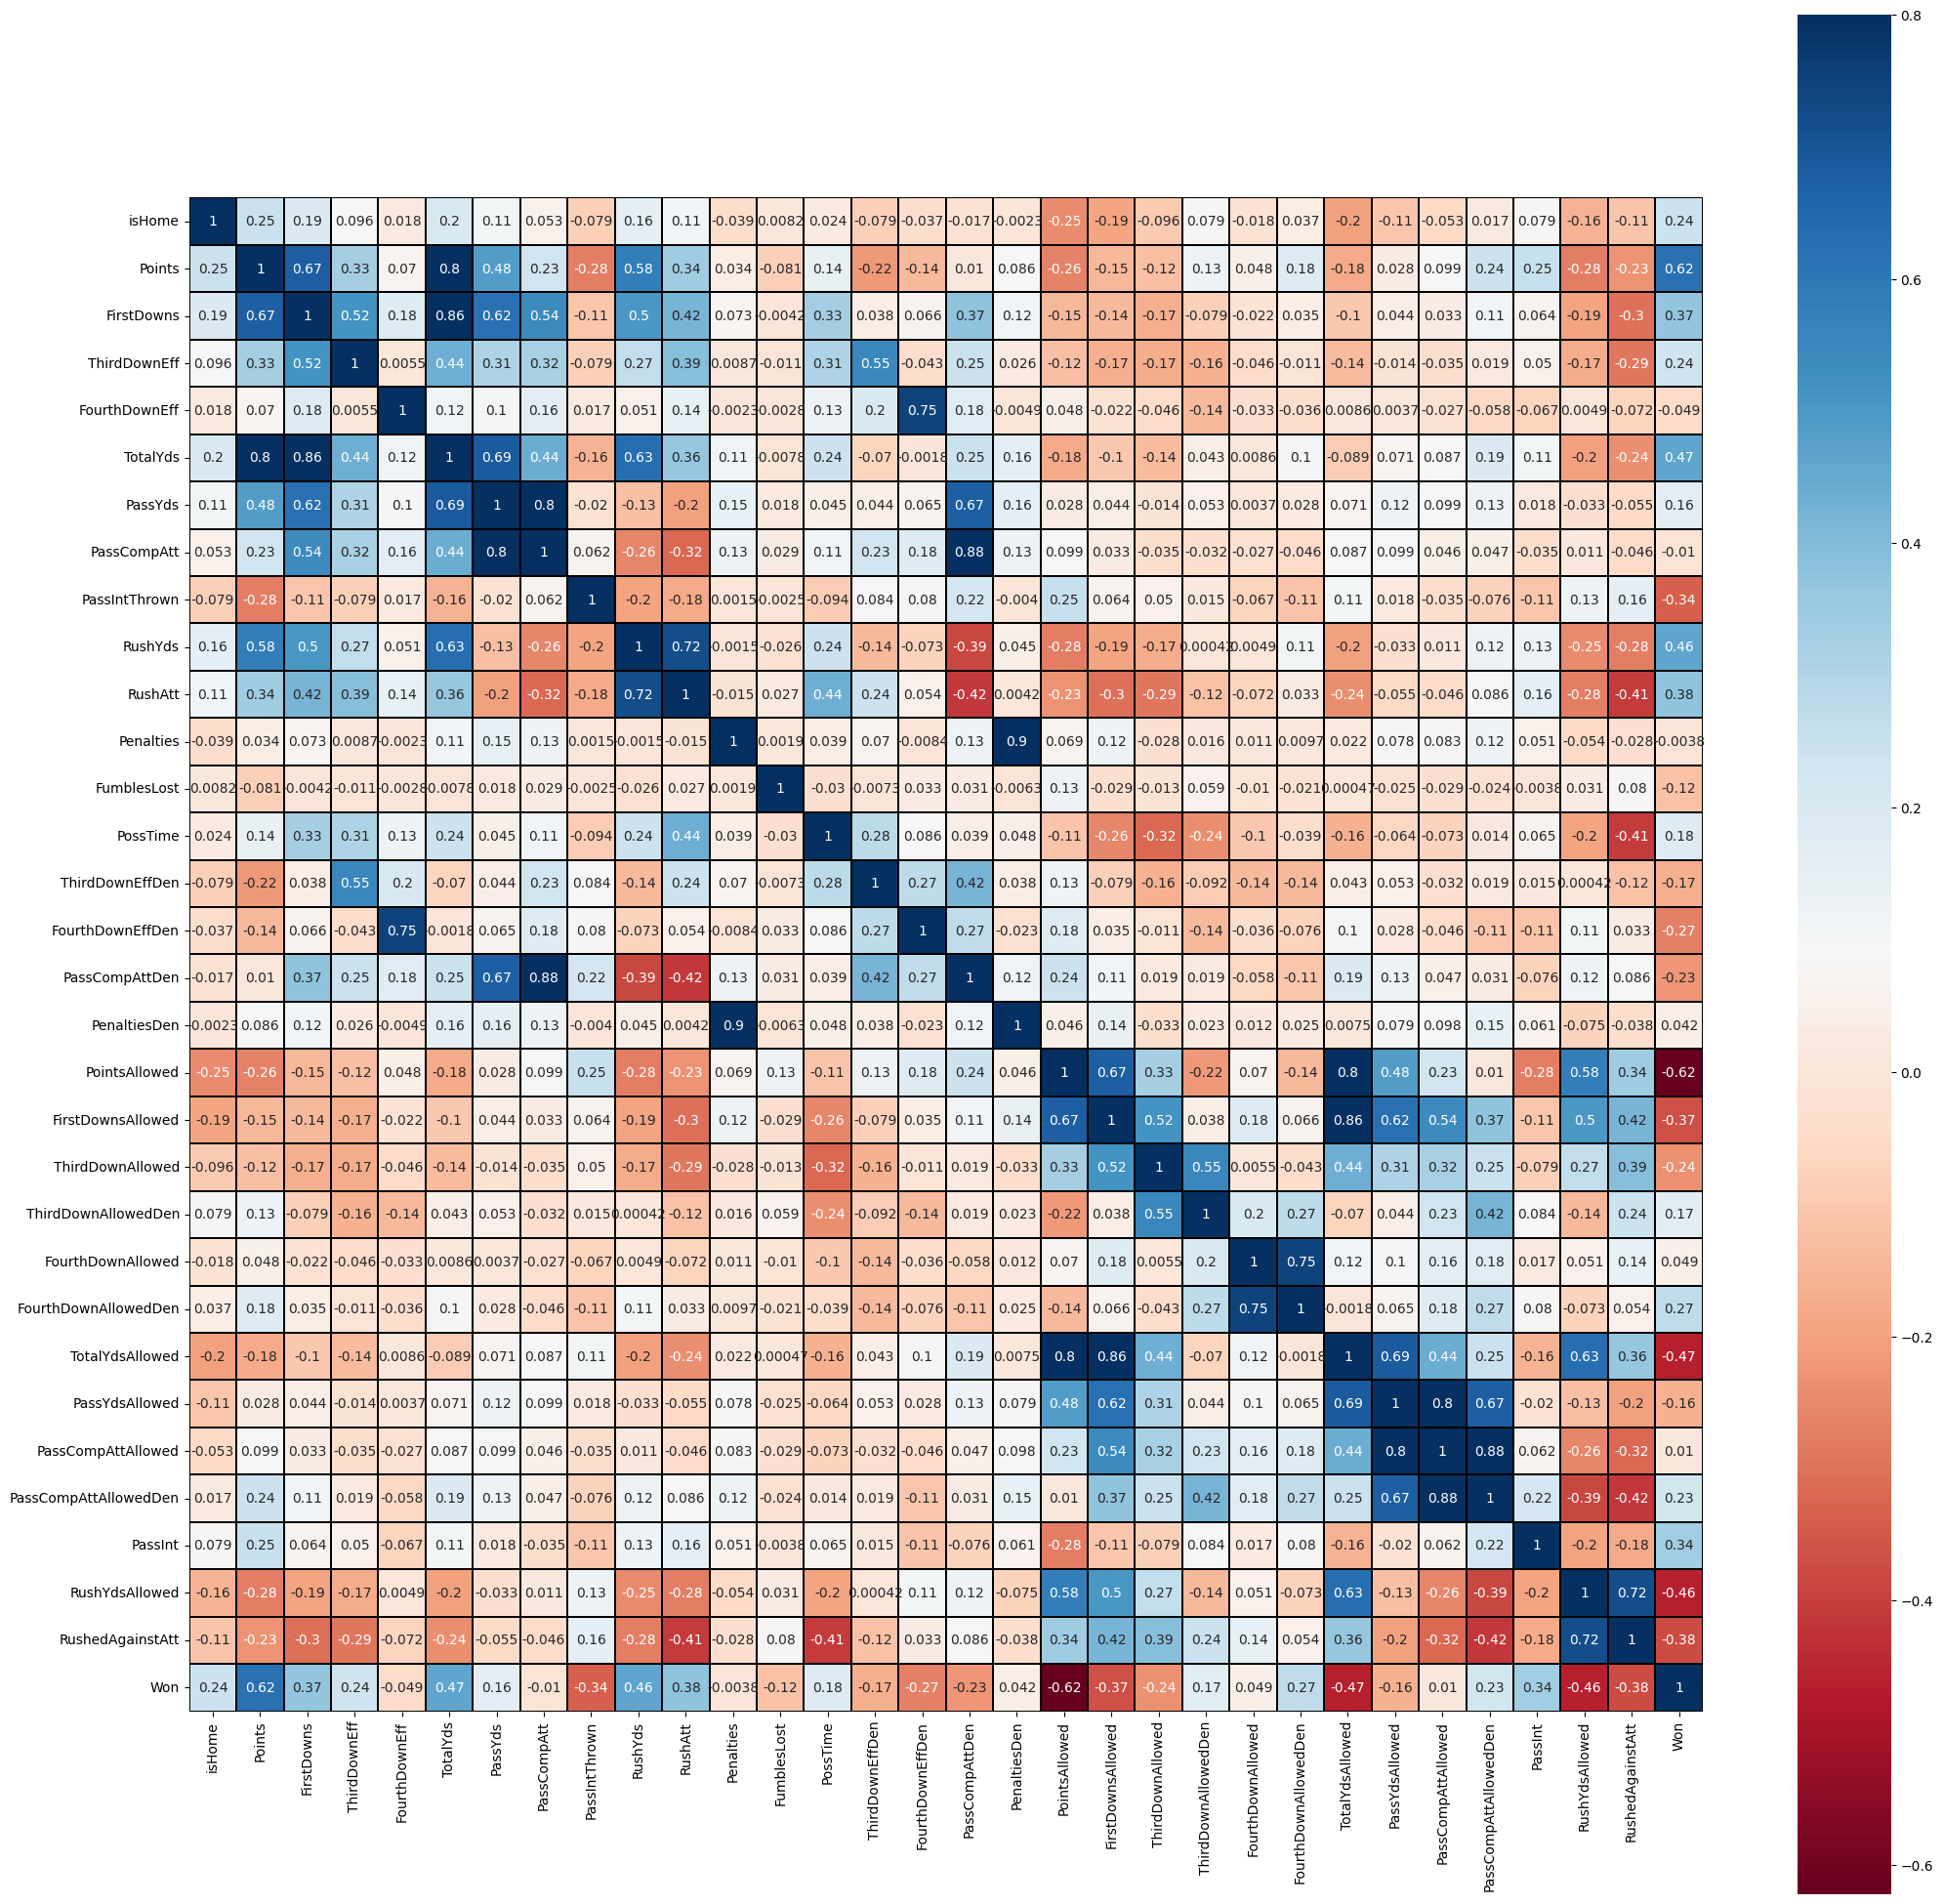

In [8]:
corr = stats_df.corr(method='pearson')
plt.figure(figsize=(25,25))
sn.heatmap(corr,vmax=.8,linewidths=0.01,square=True,annot=True,cmap='RdBu',linecolor='black')

Points and PointsAllowed have the highest correlation to winning, but maybe suprisingly they aren't that strong. This logically makes sense, as a team scoring 3 points could still win while a team scoring 50 points could still lose. While there are plenty of relationships that are somewhat correlated, there's not many that are very strong and provide useful nonobvious insight. To try and get some better insights, additional feature engineering is required.

<AxesSubplot: >

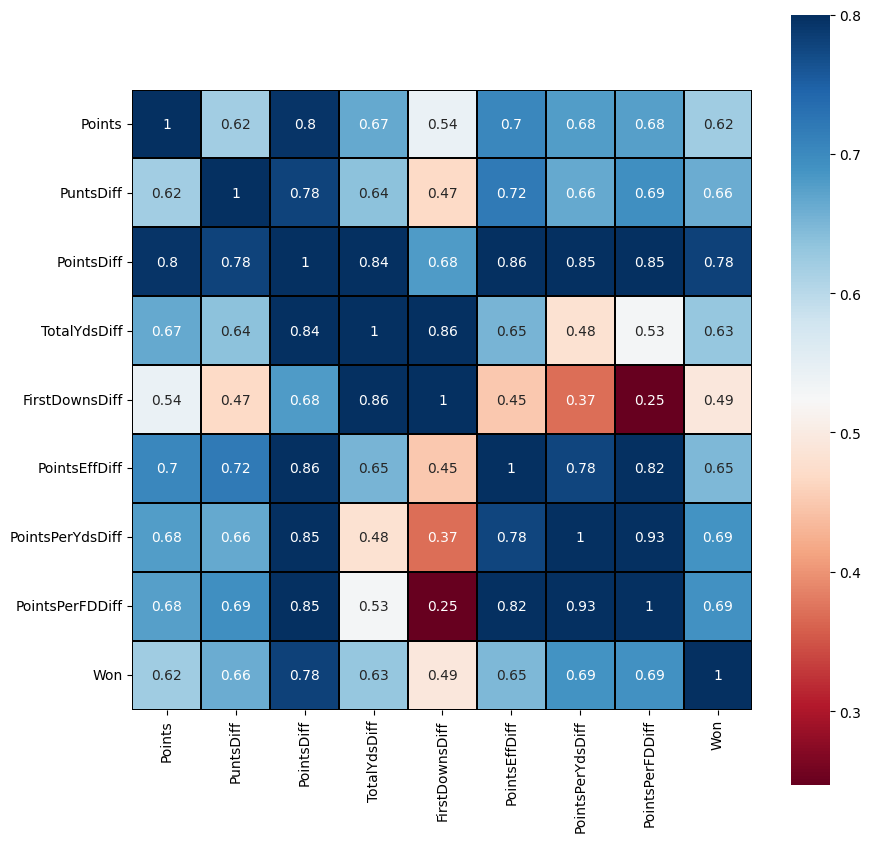

In [9]:
stats_df['Punts'] = (stats_df['ThirdDownEffDen']+stats_df['FourthDownEffDen']) - (stats_df['ThirdDownEff']+stats_df['FourthDownEff'])
stats_df['PuntsForced'] = (stats_df['ThirdDownAllowedDen']+stats_df['FourthDownAllowedDen']) - (stats_df['ThirdDownAllowed']+stats_df['FourthDownAllowed'])
stats_df['PuntsDiff'] = stats_df['PuntsForced'] - stats_df['Punts']
stats_df['PointsDiff'] = stats_df['Points'] - stats_df['PointsAllowed']
stats_df['TotalYdsDiff'] = stats_df['TotalYds'] - stats_df['TotalYdsAllowed']
stats_df['FirstDownsDiff'] = stats_df['FirstDowns'] - stats_df['FirstDownsAllowed']
stats_df['PossTimeAllowed'] = 60-stats_df['PossTime']
stats_df['PointsEff'] = round(stats_df['Points'] / stats_df['PossTime'],3)
stats_df['PointsEffAllowed'] = round(stats_df['PointsAllowed'] / stats_df['PossTimeAllowed'],3)
stats_df['PointsEffDiff'] = stats_df['PointsEff'] - stats_df['PointsEffAllowed']
stats_df['TotalYdsEff'] = round(stats_df['TotalYds'] / stats_df['PossTime'],3)
stats_df['TotalYdsEffAllowed'] = round(stats_df['TotalYdsAllowed'] / stats_df['PossTime'],3)
stats_df['PointsPerYd'] = round(stats_df['Points'] / stats_df['TotalYds'],3)
stats_df['PointsPerYdAllowed'] = round(stats_df['PointsAllowed'] / stats_df['TotalYdsAllowed'],3)
stats_df['PointsPerYdsDiff'] = stats_df['PointsPerYd'] - stats_df['PointsPerYdAllowed']
stats_df['PointsPerFD'] = round(stats_df['Points'] / stats_df['FirstDowns'],3)
stats_df['PointsPerFDAllowed'] = round(stats_df['PointsAllowed'] / stats_df['FirstDownsAllowed'],3)
stats_df['PointsPerFDDiff'] = stats_df['PointsPerFD'] - stats_df['PointsPerFDAllowed']


corr = stats_df[['Points', 'PuntsDiff', 'PointsDiff', 'TotalYdsDiff', 'FirstDownsDiff', 'PointsEffDiff', 'PointsPerYdsDiff', 'PointsPerFDDiff', 'Won']].corr(method='pearson')
plt.figure(figsize=(10,10))
sn.heatmap(corr,vmax=.8,linewidths=0.01,square=True,annot=True,cmap='RdBu',linecolor='black')

The new features are higher correlated compared to most of the original features. Notably, PointsEffDiff is an interesting standout being highly correlated with PointsPerFDDiff. PointsPerFDDiff is the best scoring feature in terms of correlation to Winning. The correlation is higher to winning than Points alone which seems to suggest that winning is less about how many points a team can score but rather how fast a team can score and how many explosive plays a team can generate relative to their opponent. <br>
<br>
Many of the new features are correlated with each other, so it's important to be cognizant that the model ultimately selected isn't largely affected by multicollinearity.

Because the "Won" label is binary it's by definition ordinal and as such can be used as either categorical or continuous. This allows for several different options in terms of model selection. 

In [31]:
from random import sample
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


models = [
    GaussianNB(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    SVC(),
    KNeighborsClassifier()
    
]


feature_cols = flt_features.drop(['PointsDiff'], axis=1).columns

sample_hist = None
test_hist = None


def chooseModel(models, features, gethist=False, sample_hist=sample_hist, test_hist=test_hist):
    topscore = 0
    clf = None

    for model in models:
        scores = []

        sample_stats = stats_df.sample(frac=0.8, random_state=randint(1,20))
        test_stats = stats_df.merge(sample_stats, how='left', indicator=True)
        test_stats = test_stats[test_stats['_merge'] == 'left_only']

        if gethist:
            sample_hist = sample_stats[features].hist()
            test_hist = test_stats[features].hist()

        xfeatures_train = sample_stats.loc[:, features]
        yresponse_vector_train = sample_stats.Won

        model.fit(xfeatures_train, yresponse_vector_train)
        
        xfeatures_predict = test_stats.loc[:, features]
        yresponse_vector_score = test_stats.Won
        s = model.score(xfeatures_predict, yresponse_vector_score)
        
        print(f'''{model.__class__.__name__} Score: {s}''')
        
        if s > topscore:
            topscore = s
            clf = model
    if len(models) > 1:
        print(f'''\nBased on these results, the Classification Model to use is {clf.__class__.__name__}''')
    return clf

winClassifier = chooseModel(models, feature_cols)



GaussianNB Score: 0.9563275434243176
RandomForestClassifier Score: 0.9896039603960396
AdaBoostClassifier Score: 0.9835164835164835
SVC Score: 0.9123069257598405
KNeighborsClassifier Score: 0.8041958041958042

Based on these results, the Classification Model to use is RandomForestClassifier


Analyzing feature importance shows the impact of some of the engineered features. Cleary PointsEffDiff and PointsPerFDDiff were well engineered in that they acheive dimensionality reduction as well as capture qualities of high importance. These two features will be the starting point for the feature selection process.

In [12]:
fimportance = pd.DataFrame()
fimportance['feature'] = list(feature_cols)
fimportance['score'] = list(winClassifier.feature_importances_)
fimportance.sort_values('score', ascending=False, ignore_index=True)


,feature,score
0,PointsEffDiff,0.112109
1,PointsPerFDDiff,0.110620
2,PointsPerYdsDiff,0.108069
3,Points,0.074984
4,TotalYdsDiff,0.069914
5,PointsAllowed,0.066982
6,PuntsDiff,0.056848
7,PointsPerFDAllowed,0.037353
8,PointsPerFD,0.036329
9,FirstDownsDiff,0.034187


Visualizing the most important features helps show the apparent boundaries for the 'Won' label. PointsPerFdDiff implies that teams that score more on shorter drives than their opponent are more likely to win. PointsEffDiff implies teams that score faster than their opponent are more likely to win.

<AxesSubplot: xlabel='PointsEffDiff', ylabel='PointsPerFDDiff'>

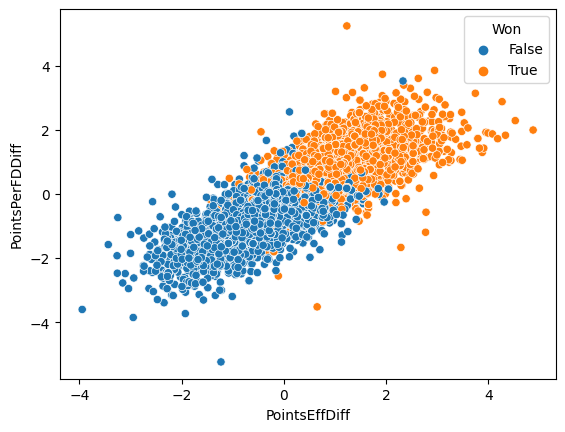

In [ ]:
sn.scatterplot(data=stats_df, x='PointsEffDiff', y='PointsPerFDDiff', hue='Won')



Knowing the sport, something that would pair well with these two qualities would be the given team having more first down opportunities relative to their opponent. FirstDownsDiff will logically exacerbate the win chance provided by the other two features. 

These three features combined provide several other implications for winning teams and captures factors difficult to quantify using available data, such as:

 * Big turnovers resulting in good field position
 * Big special teams plays resulting in good field position
 * Defense getting off the field by forcing punts/turnovers
 * Controlling the tempo of the game
 * Maintaining initiative and/or momentum
 * Capitalizing on scoring opportunities

The goal is to narrow down the number of features needed to accurately identify a win. With these 3 features we can describe a combination of factors and actions by a team that ultimately lead to victory in a given game. This provides a more robust picture of a team's performance compared to looking at just Yds or Score.


RandomForestClassifier Score: 0.9593455627169063


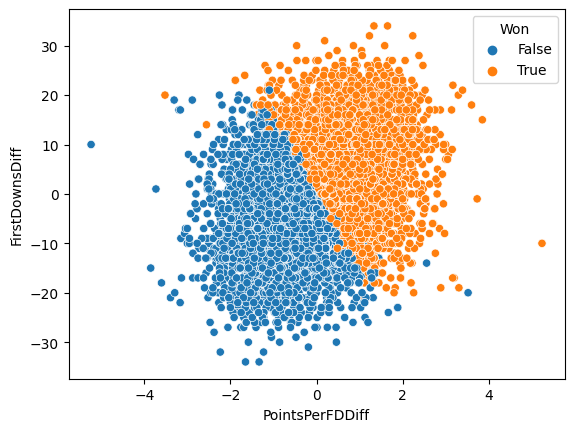

<AxesSubplot: xlabel='PointsEffDiff', ylabel='FirstDownsDiff'>

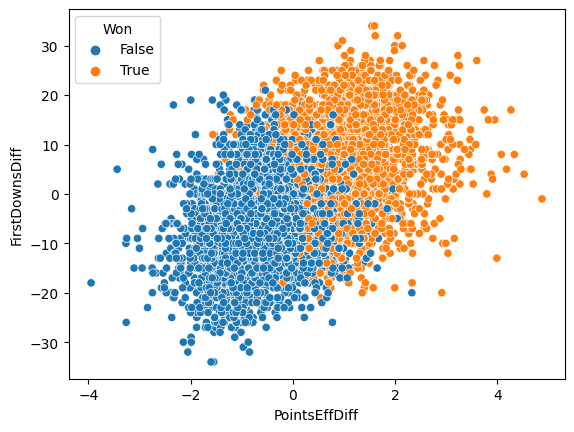

In [39]:
winClassifier = chooseModel([RandomForestClassifier()], ['PointsPerFDDiff', 'FirstDownsDiff'])

sn.scatterplot(data=stats_df, x='PointsPerFDDiff', y='FirstDownsDiff', hue='Won')
plt.show()
sn.scatterplot(data=stats_df, x='PointsEffDiff', y='FirstDownsDiff', hue='Won')

The relationship between FirstDownsDiff and PointsPerFDDiff provides the clearest separation between winning and losing. Using just these features in the model scores very high. There is still some room for improvement so as long as PointEffDiff affects the model positively, it's worth keeping in as it provides additonal context to a given team's typical strategy and playstyle.

RandomForestClassifier Score: 0.9737638748738647


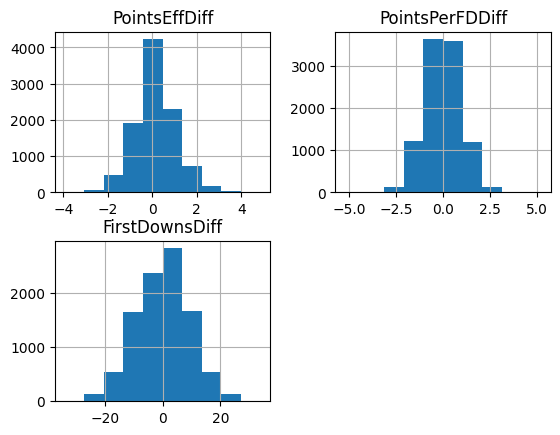

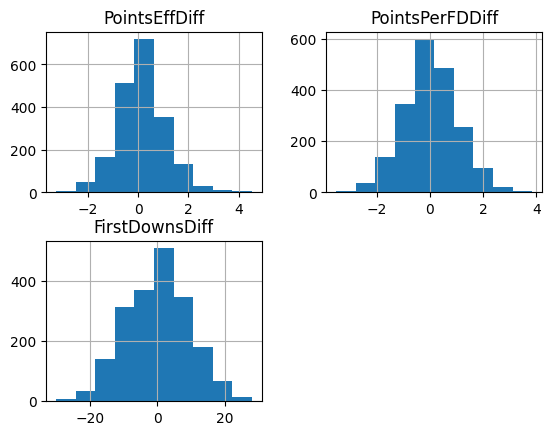

In [42]:
winClassifier = chooseModel([RandomForestClassifier()], ['PointsEffDiff', 'PointsPerFDDiff', 'FirstDownsDiff'], gethist=True)

The next step is to build a model or models that accurately predict these three highly descriptive features.

 * PointsEffDiff
 * PointsPerFDDiff
 * FirstDownsDiff

Seeing as there is a normal distribution within the training and test sets for each feature, a given team could be scored based on average performance against the mean given the average variance of past opponents in a given season. This bodes well for running monte carlo simulations as a means for win predictions.

***
### Predicting features of later games within a season

The data now needs to be organized in more of a time series fashion and grouped by season. Samples taken are deliberately spread out over many seasons to help provide the best generalization. Techniques frequently used in sports betting can be applied for the purposes of this analysis to help predict the features determined in the prior section.

Getting the data in the right structure requires additional data engineering to develop the dataset into a more conducive structure. This is acheived with the following query and pulled into a dataframe.

In [17]:
qry = '''

WITH gmdate AS (
  SELECT
    GameID,
    YEAR,
    PARSE_DATE("%a %b %e %Y", CONCAT(REGEXP_REPLACE(GameDate, ',', ''), ' ', YEAR)) AS GameDate,
    Team
  FROM `portfolio-project-353016.collegeFootball.Game_Team_Stats`
  JOIN `portfolio-project-353016.collegeFootball.Power_5_Games`
  USING(GameID)
  WHERE 1=1
    AND PossTime LIKE '%:%' 
    AND GameID != '302750030' 
),

homegamesstep1 AS (
  SELECT
    GameID,
    Team,
    CAST(Points AS INT64) AS Points,
    CAST(FirstDowns AS INT64) AS FirstDowns,
    CAST(SPLIT(PossTime, ':')[OFFSET(0)] AS INT64) + ROUND((CAST(SPLIT(PossTime, ':')[OFFSET(1)] AS INT64)/60),2) AS PossTime
  FROM `portfolio-project-353016.collegeFootball.Game_Team_Stats`
  WHERE 1=1
    AND PossTime LIKE '%:%' 
    AND GameID != '302750030'
    AND isHome
),

awaygamesstep1 AS (
  SELECT
    GameID,
    Team,
    CAST(Points AS INT64) AS Points,
    CAST(FirstDowns AS INT64) AS FirstDowns,
    CAST(SPLIT(PossTime, ':')[OFFSET(0)] AS INT64) + ROUND((CAST(SPLIT(PossTime, ':')[OFFSET(1)] AS INT64)/60),2) AS PossTime
  FROM `portfolio-project-353016.collegeFootball.Game_Team_Stats`
  WHERE 1=1
    AND PossTime LIKE '%:%' 
    AND GameID != '302750030'
    AND NOT isHome
),

homegames AS (
  SELECT
    GameID,
    a.Team,
    a.Points,
    a.PossTime,
    a.FirstDowns,
    b.Points AS PointsAllowed,
    b.PossTime AS PossTimeAllowed,
    b.FirstDowns AS FirstDownsAllowed
  FROM homegamesstep1 a
  JOIN awaygamesstep1 b
  USING(GameID)
),

awaygames AS (
  SELECT
    GameID,
    a.Team,
    a.Points,
    a.PossTime,
    a.FirstDowns,
    b.Points AS PointsAllowed,
    b.PossTime AS PossTimeAllowed,
    b.FirstDowns AS FirstDownsAllowed
  FROM awaygamesstep1 a
  JOIN homegamesstep1 b
  USING(GameID)
),

agg AS (
  SELECT
    DISTINCT
    *
    FROM gmdate
    JOIN (
      SELECT * FROM homegames
      UNION ALL
      SELECT * FROM awaygames
    )
    USING(GameID, Team)
),

features AS (
  SELECT
    GameID,
    Team,
    YEAR,
    GameDate,
    ROUND(ROUND(Points/PossTime,3) - ROUND(PointsAllowed/PossTimeAllowed,3),3) AS PointsEffDiff,
    ROUND(ROUND(Points/FirstDowns,3) - ROUND(PointsAllowed/FirstDownsAllowed,3),3) AS PointsPerFDDiff,
    (FirstDowns - FirstDownsAllowed) AS FirstDownsDiff
  FROM agg
)

SELECT * FROM features ORDER BY YEAR, GameDate


'''


games_df = client.query(qry).result().to_dataframe()
games_df.head()

,GameID,Team,YEAR,GameDate,PointsEffDiff,PointsPerFDDiff,FirstDownsDiff
0,310010127,Alabama Crimson Tide,2010,2010-01-01,2.054,1.377,13
1,310010127,Michigan State Spartans,2010,2010-01-01,-2.054,-1.377,-13
2,310010130,Mississippi State Bulldogs,2010,2010-01-01,1.440,1.176,9
3,310010130,Michigan Wolverines,2010,2010-01-01,-1.440,-1.176,-9
4,310010201,Oklahoma Sooners,2010,2010-01-01,0.930,0.725,8


The training set will need to be split up by season and team while limited to first 3 games, 6 games, and 9 games of a season.

In [18]:

#monte carlo sim setup

#adjusting stats
    #power5 averages need to be calculated week to week to help determine the average power5 opponent on a neutral field
        #this helps normalize the values team to team
        #comparing each team against the normalized values (power5 avgs) helps compare apples to apples
    #actual opponent should be adjusted based on teams average difference to power5 opponent average
        #look at season to date avg for team compare to season to date avg for power5 teams
        #team avg - pwr5 avg = delta
    #adjusted features = team1 delta + team1 opponents delta avg(sum all opponent deltas divided by number of opponents)
    #iterate multiple times?

#Predictions
    #when finding power5 avg, limit delta = (IQR*1.5)/2
    #for each team
        #random value between lower limit(team avg - limit delta) and upper limit(team avg + limit delta)
    #calculate PointsEffDiff, PointsPerFDDiff and FirstDownsDiff
    #run values through classification model
    #find percentage of win/loss through 1000 iterations for percent chance to win


#take training sample by every other year or every two years
    #train on front half, test on back half?


#additional data wrangling:

#create dictionary with each season, each team and their opponents to easily loop through to calculate team's opponents delta avg
# d = { 
#     2021: [
#         {
#             'team1': [
#                 'opp1', 
#                 'opp2'
#             ],
#             'team2' : [
#                 'opp1', 
#                 'opp2'
#             ]
#         }
#     ],
#     2022: [
#         {
#             'team1': [
#                 'opp1', 
#                 'opp2'
#             ],
#             'team2' : [
#                 'opp1', 
#                 'opp2'
#             ]
#         }
#     ]
# }